In [2]:
!pip show tensorflow

Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/harsh/mynlpenv/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-macos


In [ ]:
# Imports
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

In [4]:
data = pd.read_csv('MicrosoftStock.csv')
print(data.head())
print(data.info())
print(data.describe())

    index        date   open   high    low  close    volume  Name
0  390198  2013-02-08  27.35  27.71  27.31  27.55  33318306  MSFT
1  390199  2013-02-11  27.65  27.92  27.50  27.86  32247549  MSFT
2  390200  2013-02-12  27.88  28.00  27.75  27.88  35990829  MSFT
3  390201  2013-02-13  27.93  28.11  27.88  28.03  41715530  MSFT
4  390202  2013-02-14  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   date    1259 non-null   object 
 2   open    1259 non-null   float64
 3   high    1259 non-null   float64
 4   low     1259 non-null   float64
 5   close   1259 non-null   float64
 6   volume  1259 non-null   int64  
 7   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(2)
memory usage: 78.8+ KB
None
               index         open  ...        close        v

Text(0, 0.5, 'Price (USD)')

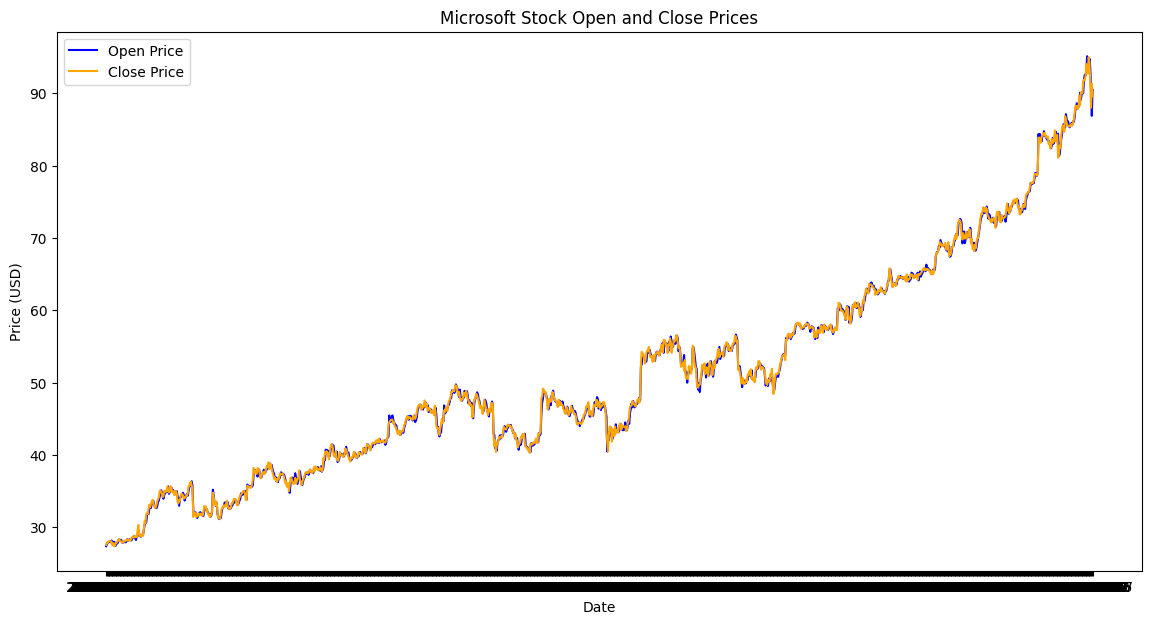

In [6]:
# Initial data visualization 
# Plot 1 : Open and Close prices
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['open'], label='Open Price', color='blue')
plt.plot(data['date'], data['close'], label='Close Price', color='orange')
plt.title('Microsoft Stock Open and Close Prices')
plt.xlabel('Date')
plt.legend()
plt.ylabel('Price (USD)')

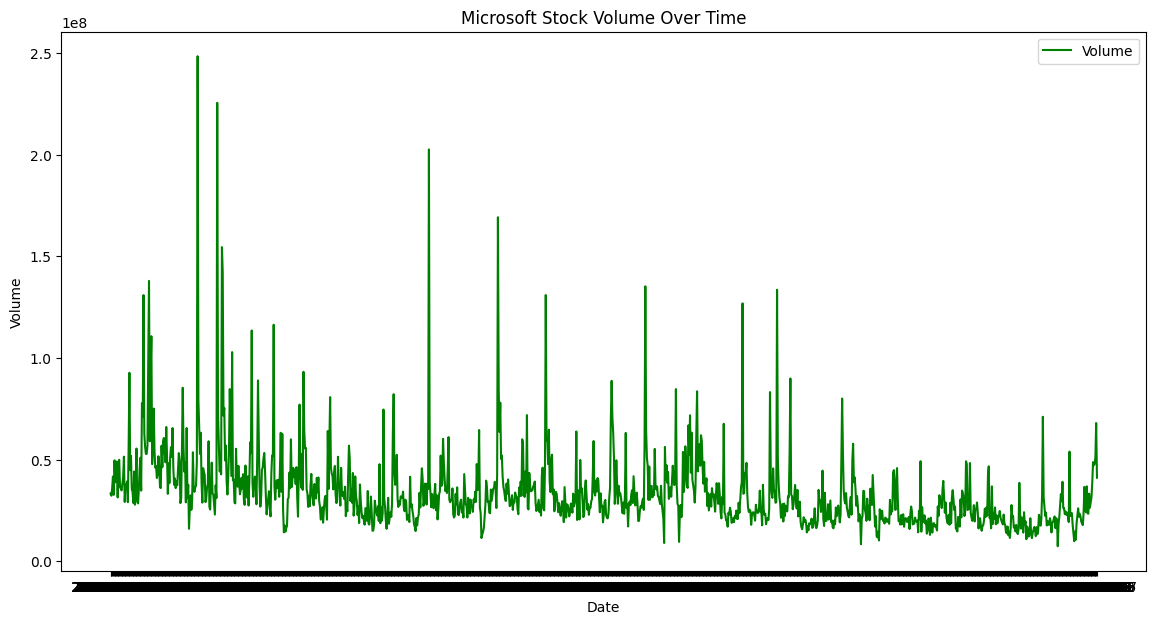

In [7]:
# Plot 2 : Volume over time
plt.figure(figsize=(14, 7))
plt.plot(data['date'], data['volume'], label='Volume', color='green')
plt.title('Microsoft Stock Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()


In [8]:
# Drop unnecessary columns (non-numeric or redundant)
numeric_data = data.select_dtypes(include=["int64", "float64"])

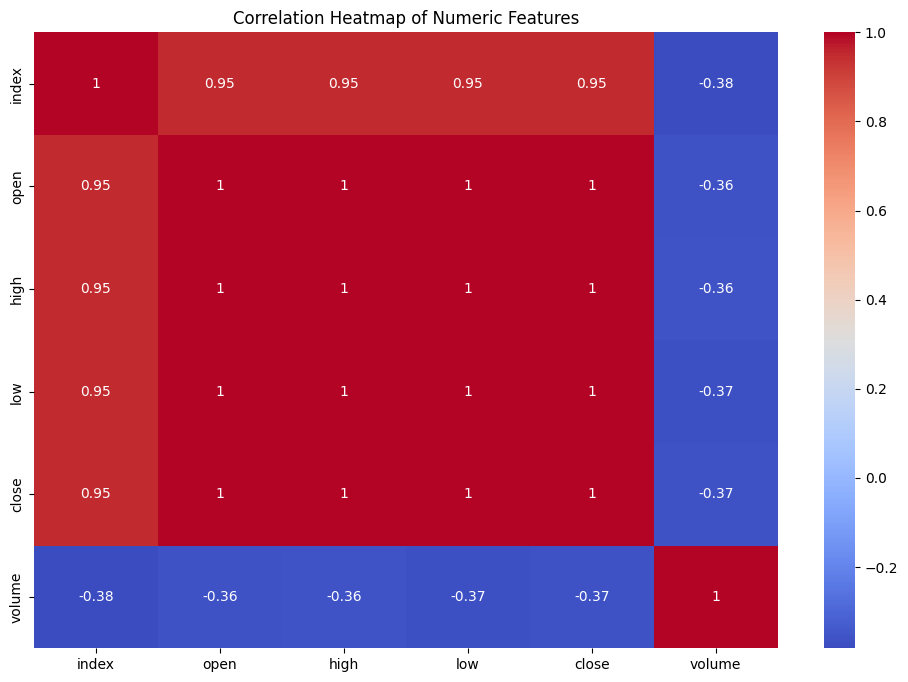

In [9]:
# Check for correlation between numeric features
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [10]:
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [ ]:
prediction = data.loc[
    (data['date'] > datetime(2013,1,1)) & (data['date'] < datetime(2018,1,1))
]

In [12]:
# Prepare the LSTM Model (Sequential)
dataset = data['close'].values 
train_size = int(np.ceil(len(dataset) * 0.95))

In [16]:
print(dataset.reshape(-1, 1).shape)

(1259, 1)


In [ ]:
# Data Preprocessing
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.reshape(-1, 1))
training_data = scaled_data[:train_size]

In [21]:
X_train, y_train = [], []

# Create a sliding window of 60 days for the stock
for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [22]:
print(X_train.shape)

(1137, 60)


In [23]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # Making it 3D for Tensorflow
print(X_train.shape)

(1137, 60, 1)


# Building the Model

In [24]:
model = keras.models.Sequential()

In [ ]:
# First layer - learns the patterns from past 60 days of stock prices 
model.add(keras.layers.LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))

2025-06-14 19:45:50.338191: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-14 19:45:50.338836: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-06-14 19:45:50.338846: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-06-14 19:45:50.338932: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-14 19:45:50.339256: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/harsh/mynlpenv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models

In [ ]:
# Second layer - This layer keeps the important features from the first layer
model.add(keras.layers.LSTM(units=64, return_sequences=False))

In [ ]:
# Third Layer (Dense Layer) - This layer helps the model adjust and learn complex patterns in the data
model.add(keras.layers.Dense(units=128, activation='relu'))

In [ ]:
# Fourth Layer (Dropout Layer) , to prevent overfitting - it prevents the model from being too sensitive to the training data and helps it perform better on new data
model.add(keras.layers.Dropout(0.5))

In [ ]:
# Final output layer - This layer predicts the stock prices 
model.add(keras.layers.Dense(units=1)) 

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,369 (228.00 KB)

 Trainable params: 58,369 (228.00 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model.compile(optimizer='adam', loss='mae', metrics=[keras.metrics.RootMeanSquaredError()])

# Train the model

In [34]:
training = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


2025-06-14 19:50:23.487697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.3899 - root_mean_squared_error: 0.5223
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1147 - root_mean_squared_error: 0.1541
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0975 - root_mean_squared_error: 0.1338
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0961 - root_mean_squared_error: 0.1300
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0970 - root_mean_squared_error: 0.1323
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1004 - root_mean_squared_error: 0.1377
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0918 - root_mean_squared_error: 0.1223
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.1009 - root_mean_squared_error: 0.1383
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0971 - root_mean_squared_error: 0.1283
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0966 - root_mean_squared_error: 0.1299
Epoch 11/2

In [35]:
# Prep test data
test_data = scaled_data[train_size - 60:]
X_test, y_test = [], dataset[train_size:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [36]:
# Make predictions 
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


/var/folders/lk/9zql6l_s4fn6rj08c1xp00k00000gn/T/ipykernel_23643/3723204049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


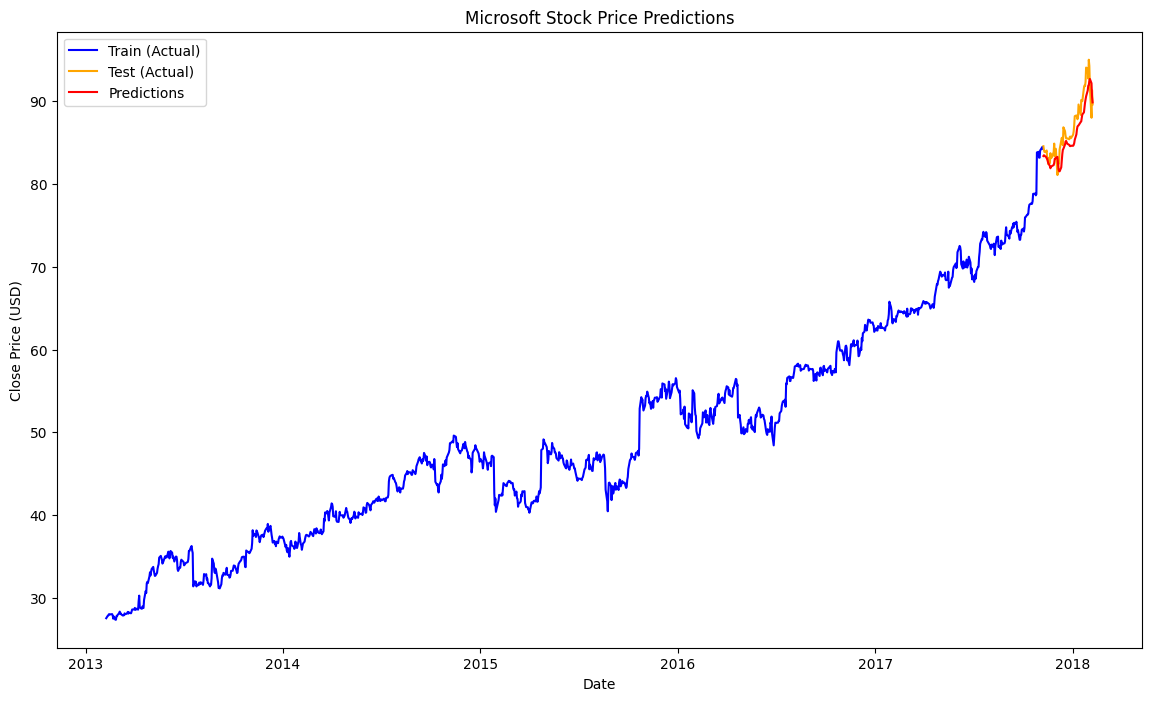

In [37]:
# Plotting data
train = data[:train_size]
test = data[train_size:]
test['Predictions'] = predictions
plt.figure(figsize=(14, 8))
plt.plot(train['date'], train['close'], label='Train (Actual)', color='blue')
plt.plot(test['date'], test['close'], label='Test (Actual)', color='orange')
plt.plot(test['date'], test['Predictions'], label='Predictions', color='red')
plt.title('Microsoft Stock Price Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()